In [1]:
import os, gzip, pickle

import pandas as pd
import numpy as np

from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools

from rdkit import Chem, rdBase, RDConfig
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps, FeatMapUtils
from rdkit.Chem.FeatMaps.FeatMapUtils import CombineFeatMaps

import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go

In [2]:
pkl_file = open('featurestein-69.p', 'rb')
fmaps = pickle.load(pkl_file)
fmaps

In [3]:
fmaps.params

{'Donor': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f9690377d30>,
 'Acceptor': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f9690377760>,
 'NegIonizable': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f9690377850>,
 'PosIonizable': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f9690377790>,
 'ZnBinder': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f9690377970>,
 'Aromatic': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f9690377940>,
 'Hydrophobe': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f96903779d0>,
 'LumpedHydrophobe': <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams at 0x7f96903778e0>}

In [4]:
# Setting up the features to use in FeatureMap
ffact = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

fmParams = {}
for k in ffact.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

def filterFeature(f):
    result = f.GetFamily() in keep
    return result

def getRawFeatures(mol):
    rawFeats = ffact.GetFeaturesForMol(mol)
    # filter that list down to only include the ones we're interested in
    filtered = list(filter(filterFeature, rawFeats))
    return filtered

def getFeatureMap(mol):
    feats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(feats),params=fmParams)

def gen_feats(mol):
    rawFeats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(rawFeats), params=fmParams)

def score_featmaps(fm1, fm2):
    "Generate the score for 2 feature maps"
    if fm1.GetNumFeatures() == 0:
        return 0
    else:
        return fm1.ScoreFeats(fm2.GetFeatures()) / fm1.GetNumFeatures()

def gen_fmap_score(mol):
    name = mol.GetProp('_Name')
    featMap = getFeatureMap(mol)
    score = score_featmaps(featMap, fmaps)
    return score

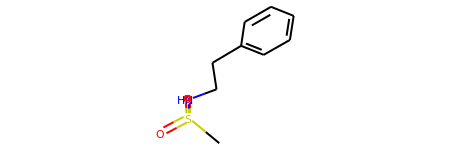

In [5]:
# Run a simple test - the Mpro-x0072 hit which should score close to 1.0
mol = Chem.MolFromMolFile('../data/misc/Mpro-x0072.mol')
mol

In [6]:
score = gen_fmap_score(mol)
score

0.9538538108436915

In [7]:
df = PandasTools.LoadSDF('Fragmenstein_permissive_rescored_20200609.sdf.gz', molColName='Molecule')
df.shape

(7677, 20)

In [8]:
df.dtypes

method                   object
disregarded              object
N_constrained_atoms      object
submitter_name           object
ref_pdb                  object
∆∆G                      object
submitter_institution    object
generation_date          object
%Rank                    object
ref_url                  object
runtime                  object
smiles                   object
original SMILES          object
ref_mols                 object
regarded                 object
submitter_email          object
comRMSD                  object
N_unconstrained_atoms    object
ID                       object
Molecule                 object
dtype: object

,method,disregarded,N_constrained_atoms,submitter_name,ref_pdb,∆∆G,submitter_institution,generation_date,%Rank,ref_url,runtime,smiles,original SMILES,ref_mols,regarded,submitter_email,comRMSD,N_unconstrained_atoms,ID,Molecule
1,nan,x0305,38,nan,nan,-15.551701,nan,nan,0.014188,nan,45.272945,CC(=O)NCCc1c2cc(F)cc(C(CN(Cc3cc(C)on3)C(=O)NC3...,nan,"x0104,x0395,x0397,x0305","x0104,x0395,x0397",nan,0.625860,0,FRA-DIA-8640f307-1,
2,nan,,40,nan,nan,-14.355297,nan,nan,0.028377,nan,43.082023,CC(=O)NCCc1c2cc(C#N)cc(C(CN(Cc3cc(C)on3)C(=O)N...,nan,"x0104,x0305,x0395,x0397","x0104,x0305,x0395,x0397",nan,0.855771,0,FRA-DIA-8640f307-2,
3,nan,"x0161,x0426,x0397",35,nan,nan,-11.046305,nan,nan,0.042565,nan,1346.65659,O=C(CN(C(=O)Nc1ccccc1)c1cccnc1)N1CCN(S(=O)(=O)...,nan,"x0434,x0731,x0161,x0426,x0397","x0434,x0731",nan,0.452840,0,SIM-SYN-a98e6a07-1,
4,nan,,41,nan,nan,-11.238756,nan,nan,0.056754,nan,95.768548,*C(=N)N1CC(c2nc3cc(Cc4ccc(S(N)(=O)=O)cc4)ccc3s...,nan,"x0161,x0749,x0981","x0161,x0749,x0981",nan,0.853052,2,DAV-CRI-f9b12666-9-nitrile,
5,nan,,40,nan,nan,-12.12691,nan,nan,0.070942,nan,62.325956,*C(=N)N1CC(c2nc3c(-c4ccc(O)c(S(N)(=O)=O)c4)ccc...,nan,"x0161,x0749,x0981","x0161,x0749,x0981",nan,0.753703,3,DAV-CRI-f9b12666-8-nitrile,

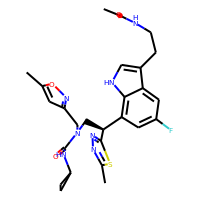
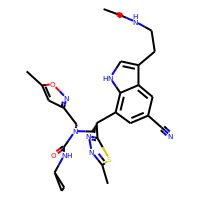
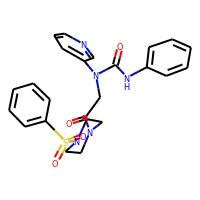
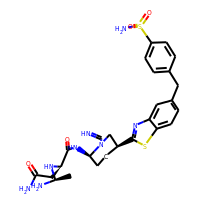
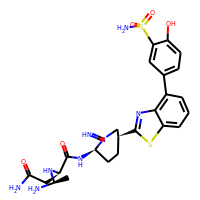

In [9]:
df2 = df.drop([0])
df2 = df2.astype(dtype= {
    "comRMSD":"float64",
    "N_constrained_atoms":"int64",
    "N_unconstrained_atoms":"int64"
})
df2.head()

In [10]:
df2['FeatureSteinScore'] = df2.apply(lambda row: gen_fmap_score(row['Molecule']), axis=1)
df2.shape

(7676, 21)

,method,disregarded,N_constrained_atoms,submitter_name,ref_pdb,∆∆G,submitter_institution,generation_date,%Rank,ref_url,...,smiles,original SMILES,ref_mols,regarded,submitter_email,comRMSD,N_unconstrained_atoms,ID,Molecule,FeatureSteinScore
1,nan,x0305,38,nan,nan,-15.551701,nan,nan,0.014188,nan,...,CC(=O)NCCc1c2cc(F)cc(C(CN(Cc3cc(C)on3)C(=O)NC3...,nan,"x0104,x0395,x0397,x0305","x0104,x0395,x0397",nan,0.625860,0,FRA-DIA-8640f307-1,,0.745606
2,nan,,40,nan,nan,-14.355297,nan,nan,0.028377,nan,...,CC(=O)NCCc1c2cc(C#N)cc(C(CN(Cc3cc(C)on3)C(=O)N...,nan,"x0104,x0305,x0395,x0397","x0104,x0305,x0395,x0397",nan,0.855771,0,FRA-DIA-8640f307-2,,0.702029
3,nan,"x0161,x0426,x0397",35,nan,nan,-11.046305,nan,nan,0.042565,nan,...,O=C(CN(C(=O)Nc1ccccc1)c1cccnc1)N1CCN(S(=O)(=O)...,nan,"x0434,x0731,x0161,x0426,x0397","x0434,x0731",nan,0.452840,0,SIM-SYN-a98e6a07-1,,0.932150
4,nan,,41,nan,nan,-11.238756,nan,nan,0.056754,nan,...,*C(=N)N1CC(c2nc3cc(Cc4ccc(S(N)(=O)=O)cc4)ccc3s...,nan,"x0161,x0749,x0981","x0161,x0749,x0981",nan,0.853052,2,DAV-CRI-f9b12666-9-nitrile,,0.495038
5,nan,,40,nan,nan,-12.12691,nan,nan,0.070942,nan,...,*C(=N)N1CC(c2nc3c(-c4ccc(O)c(S(N)(=O)=O)c4)ccc...,nan,"x0161,x0749,x0981","x0161,x0749,x0981",nan,0.753703,3,DAV-CRI-f9b12666-8-nitrile,,0.564615

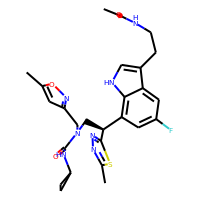
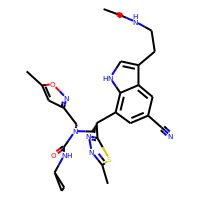
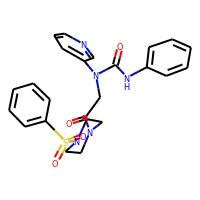
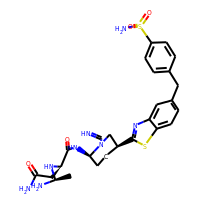
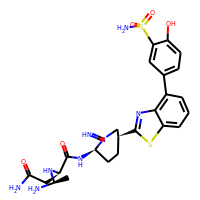

In [11]:
df2.head()

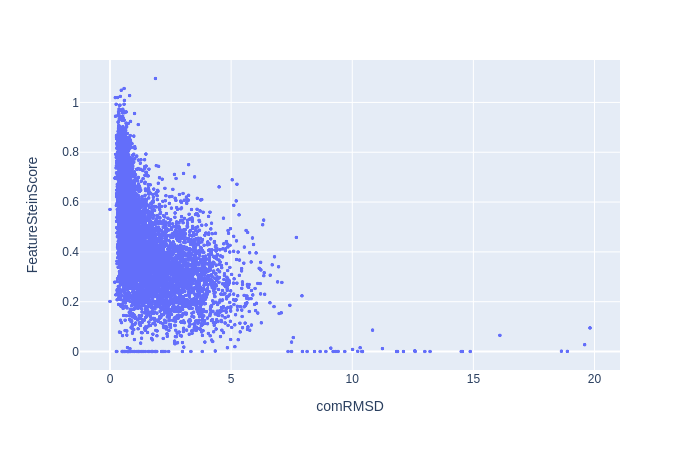

In [12]:
fig = px.scatter(df2, x="comRMSD", y="FeatureSteinScore")
fig.update_traces(mode='markers', marker_size=3)
fig.show(renderer='png')

In [13]:
# find the ones with low fragmentstein RMSD scores but good featurestein scores
# (the ones in the bottom left corner of the scatter plot). These are where fragmentstein and freaturestein
# are in most disaggreement
df3 = df2[(df2['comRMSD'] < 1) & (df2['FeatureSteinScore'] < 0.2)]          
df3.shape

(80, 21)

In [14]:
for index, row in df3.iterrows():
    print(row['ID'], row['comRMSD'], row['FeatureSteinScore'])

SAN-PRI-c9355cc8-1 0.260525 0.0
SAN-PRI-c9355cc8-2 0.283344 0.0
LYN-UNI-0d9431a4-1 0.921776 0.0
MAK-UNK-4b073b5c-9 0.502791 0.0
RAF-POL-950dada1-5 0.484335 0.18125516282765894
WAR-XCH-b6889685-48 0.517294 0.0
WAR-XCH-b6889685-49 0.507598 0.0
MAK-UNK-4b073b5c-7 0.651784 0.0
WAR-XCH-b6889685-62 0.546339 0.0
CHA-KIN-f512e507-1 0.473264 0.11564463070308274
AUS-WAB-916db9c0-2 0.627988 0.19684149699202402
WAR-XCH-b6889685-45 0.597228 0.0
MAK-UNK-4b073b5c-6 0.870365 0.09615243263785496
WAR-XCH-b6889685-46 0.744513 0.0
WAR-XCH-b6889685-44 0.61382 0.0
MAK-UNK-a7992eb3-16 0.958926 0.19589872986392343
WAR-XCH-b6889685-47 0.716617 0.0
WAR-XCH-b6889685-43 0.746322 0.0
MAK-UNK-a7992eb3-15 0.901486 0.09571185963069959
FRA-FAC-9ed5a63a-2 0.496648 0.18681137324453756
RED-SAT-26a928c9-1 0.787552 0.0
WAR-XCH-b6889685-63 0.763577 0.0
WAR-XCH-b6889685-39 0.503871 0.0
WAR-XCH-b6889685-64 0.851497 0.0
RAF-POL-8f876833-1 0.622157 0.08411837796968784
GIA-UNK-d2defdc3-2 0.675461 0.1437311073472624
SAD-SAT-29425

In [15]:
df2.dtypes

method                    object
disregarded               object
N_constrained_atoms        int64
submitter_name            object
ref_pdb                   object
∆∆G                       object
submitter_institution     object
generation_date           object
%Rank                     object
ref_url                   object
runtime                   object
smiles                    object
original SMILES           object
ref_mols                  object
regarded                  object
submitter_email           object
comRMSD                  float64
N_unconstrained_atoms      int64
ID                        object
Molecule                  object
FeatureSteinScore        float64
dtype: object

In [16]:
# keep just the properties we are interested in
df_pruned = df2[['smiles', 'Molecule', 'comRMSD', 'FeatureSteinScore', 'ref_mols']]
df_pruned.dtypes

smiles                object
Molecule              object
comRMSD              float64
FeatureSteinScore    float64
ref_mols              object
dtype: object

,smiles,Molecule,comRMSD,FeatureSteinScore,ref_mols
1,CC(=O)NCCc1c2cc(F)cc(C(CN(Cc3cc(C)on3)C(=O)NC3...,,0.625860,0.745606,"x0104,x0395,x0397,x0305"
2,CC(=O)NCCc1c2cc(C#N)cc(C(CN(Cc3cc(C)on3)C(=O)N...,,0.855771,0.702029,"x0104,x0305,x0395,x0397"
3,O=C(CN(C(=O)Nc1ccccc1)c1cccnc1)N1CCN(S(=O)(=O)...,,0.452840,0.932150,"x0434,x0731,x0161,x0426,x0397"
4,*C(=N)N1CC(c2nc3cc(Cc4ccc(S(N)(=O)=O)cc4)ccc3s...,,0.853052,0.495038,"x0161,x0749,x0981"
5,*C(=N)N1CC(c2nc3c(-c4ccc(O)c(S(N)(=O)=O)c4)ccc...,,0.753703,0.564615,"x0161,x0749,x0981"

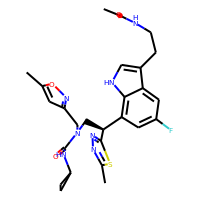
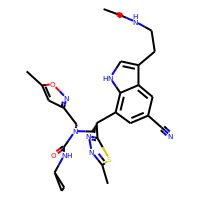
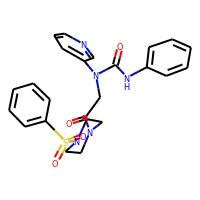
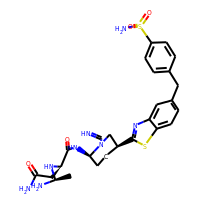
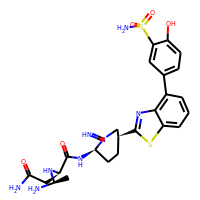

In [17]:
df_pruned.head()

## Generate the SDF for upload to Fragalysis

In [18]:
mol0 = Chem.MolFromSmiles('C')
mol0.SetProp('_Name', 'ver_1.2')
mol0.SetProp('submitter_name', 'Tim Dudgeon')
mol0.SetProp('submitter_email', 'tdudgeon@informaticsmatters.com')
mol0.SetProp('submitter_institution', 'Informatics Matters')
mol0.SetProp('generation_date', '2020-06-23')
mol0.SetProp('method', 'FeatureStein on FragmentStein run 1')
mol0.SetProp('ref_url', 'https://github.com/tdudgeon/jupyter_mpro/blob/master/featurestein/FragmentsteinScoring.ipynb')
mol0.SetProp('ref_mols', 'reference molecules')
mol0.SetProp('ref_pdb', 'Fragmentstein.pdb')
mol0.SetProp('smiles', 'molecule smiles')
mol0.SetProp('original SMILES', 'Copy of smiles column')
mol0.SetProp('comRMSD', 'Fragmentstein RMSD')
mol0.SetProp('FeatureSteinScore', 'FeatureStein Score')

In [19]:
w = Chem.SDWriter('fragmentstein4fragalysis.sdf')
w.write(mol0)

for index, row in df_pruned.iterrows():
    mol = row['Molecule']
    mol.SetProp('smiles', row['smiles'])
    mol.SetProp('original SMILES', row['smiles'])
    mol.SetProp('ref_mols', row['ref_mols'])
    mol.SetProp('ref_pdb', 'Fragmentstein.pdb')
    mol.SetDoubleProp('comRMSD', row['comRMSD'])
    mol.SetDoubleProp('FeatureSteinScore', row['FeatureSteinScore'])
    w.write(mol)

w.close()